<a href="https://colab.research.google.com/github/erichsiao1106/Aiottest/blob/master/face_age_gender0828.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.5MB/s 


In [ ]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#import tensorflow as tf
#from tensorflow import keras
import keras
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN

In [ ]:
mat = scipy.io.loadmat('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/wiki_crop/wiki.mat')
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
instances = mat['wiki'][0][0][0].shape[1]
df = pd.DataFrame(index = range(0,instances), columns = columns)
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
         array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
         array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
         array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
         array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
         array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
       dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
         array(['Dettmar Cramer'], dtype='<U14'),
         array(['Marc Okrand'], dtype='<U11'), ...,
         array(['Michael Wiesinger'], dtype='<U17'),
         array(['Johann Grugger

In [ ]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
import pandas as pd
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])
df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN
...,...,...,...,...,...,...,...,...
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN
62324,711338,1970,[32/9997032_1947-07-30_1970.jpg],1.0,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN
62326,723893,2011,[00/9999400_1981-12-13_2011.jpg],1.0,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN


In [ ]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
    
    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)
df['age'] = df['photo_taken'] - df['date_of_birth']
df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981,28
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925,39
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948,60
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930,31
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971,41
...,...,...,...,...,...,...,...,...,...,...
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN,1937,26
62324,711338,1970,[32/9997032_1947-07-30_1970.jpg],1.0,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN,1947,23
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN,1972,41
62326,723893,2011,[00/9999400_1981-12-13_2011.jpg],1.0,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN,1981,30


In [ ]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])
df

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34
...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41


In [ ]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]
df

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34
...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41


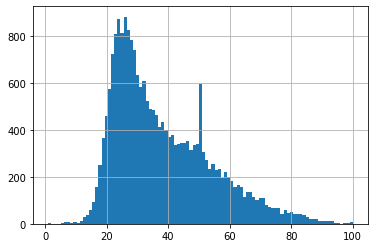

In [ ]:
histogram_age = df['age'].hist(bins=df['age'].nunique())

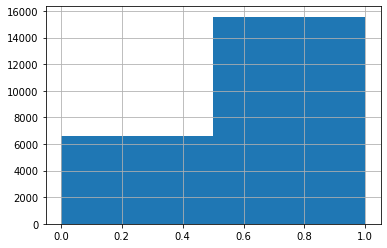

In [ ]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [ ]:
# 處理答案 把它轉成one-hot
y_train_category = to_categorical(df['age'])

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(df['full_path']), np.array(y_train_category), test_size=0.2)
print(x_train[0], x_test[0], y_train[0], y_train[0].argmax(axis=-1) y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

['18/32976818_1969-05-24_2012.jpg'] ['72/3141972_1950-02-11_2006.jpg'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
(17710,) (4428,) (17710, 101) (4428, 101)


In [ ]:
print(x_train[0], x_test[0], y_train[0], y_train[0].argmax(axis=-1))

['18/32976818_1969-05-24_2012.jpg'] ['72/3141972_1950-02-11_2006.jpg'] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] 43


In [ ]:
folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki'
detector = MTCNN()
feature_extractor = load_model(os.path.join(folder_path, 'facenet.h5'))

In [ ]:
model_age = load_model(os.path.join(folder_path, 'age100.h5'))
model_gender = load_model(os.path.join(folder_path, 'gender100.h5'))

In [ ]:
#feature_extractor.summary()

In [ ]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
#x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
#x = Flatten()(x)

x = Dense(units=1024, activation='relu')(feature_extractor.output)
x = Dense(units=101, activation='softmax')(x)
age_model = Model(inputs=feature_extractor.input, outputs=x)   
age_model.summary() 

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________

In [ ]:
age_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
# 資料預處理 for facenet?
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs
# Normalization
def normalize(img):
    return img / 255.

In [ ]:
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/wiki_crop'
def get_data(x, y, batch=20):
    # 要注意 numpy 中的 randint 的上限是不包含的 和一般的randint不同
    # numpy array 的索引可以是個 list, 即可同時取出不只一個元素
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for i,p in enumerate(x_idx):
        print(p[0])
        print(i, y_batch[i].argmax(axis=-1))
        img = np.array(load_img(os.path.join(img_folder_path,p[0]), target_size=(224, 224)))
        # 讀取圖片並使用借來的模型的預處理方式來作預處理
        img_pre = preprocess(img)
        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)

In [ ]:
# 批次訓練
for i in range(10):
    print("[times]:", i)
    _, x_batch, y_batch = get_data(x_train, y_train)
    result = age_model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    # _, x_batch, y_batch = get_data(x_test, y_test, 100)
    # result = age_model.test_on_batch(x_batch, y_batch)
    # print("[Test]:", result)

[times]: 0
61/5784661_1964-11-24_2008.jpg
0 52
70/42820470_1959-08-10_1988.jpg
1 35
09/39419509_1953-01-14_2009.jpg
2 27
14/4831314_1973-08-02_2015.jpg
3 52
12/26590712_1927-01-15_1950.jpg
4 23
54/920354_1978-12-07_2014.jpg
5 87
17/14725617_1987-05-06_2012.jpg
6 56
76/8035476_1966-01-13_1988.jpg
7 41
55/31564455_1981-05-08_2015.jpg
8 43
86/15122486_1966-06-13_2010.jpg
9 31
67/175867_1977-12-03_2006.jpg
10 29
47/25211947_1963-01-10_2012.jpg
11 53
64/16096064_1991-08-31_2013.jpg
12 26
00/18763900_1943-01-23_2008.jpg
13 24
57/396657_1926-07-09_1963.jpg
14 36
34/182534_1966-05-12_2010.jpg
15 33
48/36397448_1995-06-18_2013.jpg
16 43
33/21871933_1989-10-09_2015.jpg
17 23
22/25715722_1985-08-27_2006.jpg
18 29
14/8185414_1983-09-27_2011.jpg
19 27
[Train]: [4.750395774841309, 0.05000000074505806]
[times]: 1
55/7318055_1981-10-05_2011.jpg
0 44
67/1298267_1910-06-09_1956.jpg
1 29
57/8563357_1979-09-14_2011.jpg
2 56
29/2144329_1943-08-09_1968.jpg
3 42
02/40629802_1995-03-22_2013.jpg
4 23
05/434965

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


25/34827525_1971-04-18_2009.jpg
10 20
09/21157709_1983-07-11_2014.jpg
11 31
86/4040386_1934-02-16_2010.jpg
12 48
11/160811_1947-07-17_2014.jpg
13 43
80/512280_1890-12-25_1940.jpg
14 55
16/29924016_1897-10-16_1950.jpg
15 39
25/1303125_1982-02-25_2009.jpg
16 24
31/26776231_1989-10-27_2010.jpg
17 75
33/155033_1906-01-15_1967.jpg
18 16
67/36898267_1963-08-17_1984.jpg
19 28
[Train]: [4.789334774017334, 0.0]
[times]: 7
24/32916624_1989-10-18_2011.jpg
0 25
54/14660154_1988-07-21_2011.jpg
1 30
43/32747043_1992-10-20_2013.jpg
2 38
63/825663_1940-08-05_2012.jpg
3 43
42/20736642_1968-01-15_2010.jpg
4 84
46/16849846_1896-05-28_1953.jpg
5 25
50/41853350_1980-10-25_2013.jpg
6 52
42/2070842_1960-11-23_2010.jpg
7 24
74/35109974_1994-06-01_2012.jpg
8 36
10/27050110_1969-02-05_2012.jpg
9 72
20/13437520_1967-11-06_2014.jpg
10 38
77/2726877_1960-10-19_2012.jpg
11 31
59/20643059_1985-07-22_2009.jpg
12 76
35/13101535_1988-11-02_2014.jpg
13 67
13/42849813_1926-12-21_1954.jpg
14 50
20/41768120_1953-07-27_2014

KeyboardInterrupt: ignored

In [ ]:
# evaluate
_, x_batch, y_batch = get_data(x_test, y_test, 10)
age_model.evaluate(x_batch, y_batch)

06/5489606_1970-08-01_2008.jpg
27/3936127_1959-05-18_1980.jpg
92/1776092_1959-01-31_2007.jpg
70/2374470_1971-08-28_2013.jpg
40/19331140_1938-04-26_2015.jpg
32/8453232_1988-04-15_2015.jpg
41/28824741_1987-10-01_2013.jpg
52/2380952_1981-06-08_2009.jpg
39/419039_1949-02-09_2001.jpg
78/40076878_1991-01-18_2014.jpg
1/1 [==============================] - 0s 2ms/step - loss: 4.1845 - accuracy: 0.1000


[4.184473514556885, 0.10000000149011612]

In [ ]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

In [ ]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [ ]:
def predict_age(img):
    img_size = 100
    img = normalize(img)
    img = cv2.resize(img, (img_size, img_size))
    model_input = np.zeros((1, img_size, img_size, 3))
    model_input[0] = img
    ages = age_model.predict(model_input)
    print('age: ', ages.argmax(axis=-1))
    return 

# def predict_gender(img):
#     img_size = 100
#     img = normalize(img)
#     img = cv2.resize(img, (img_size, img_size))
#     model_input = np.zeros((1, img_size, img_size, 3))
#     model_input[0] = img
#     genders = model_gender.predict(model_input)
#     gender = genders[0]
#     if gender > 0.5:
#         print('Male')
#     else:
#         print('Female')
#     return    

In [ ]:
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]
        # More predictions
        predict_age(face)
        # predict_emotion(face)
        # predict_gender(face)
        # # ID
        # face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        # model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        # model_input[0] = face
        # model_input = preprocess(model_input)
        # query_embeddings = feature_extractor.predict(model_input)
        # query_embedding = query_embeddings[0]
        
        # # compute distance
        # distances = np.zeros((len(embeddings)))
        # for i, embed in enumerate(embeddings):
        #     distance = euclidean_distance(embed, query_embedding)
        #     distances[i] = distance

        # # find min distance    
        # idx_min = np.argmin(distances)
        # distance, name = distances[idx_min], names[idx_min]
        # print('name: ', name, ' distance: ',distance)

# of faces:  1
age:  [32]


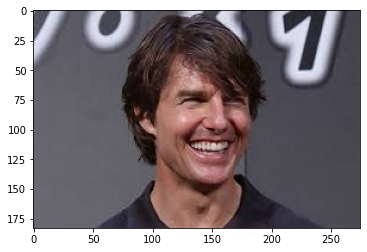

In [ ]:
folder_path = '/content/drive/My Drive/week10/face_detection'
path = 'face3.jpg'
face_id(path)
plt.imshow(cv2.imread(os.path.join(folder_path, path))[:,:,::-1])